## Accessing zarr-formatted Daymet data on Azure

The [Daymet](https://daymet.ornl.gov/) dataset contains daily minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length at 1km resolution for North America. The dataset covers the period from January 1, 1980 to December 31, 2019.

Daymet is available in both NetCDF and Zarr format on Azure; this notebook demonstrates access to the Zarr data, which can be read into an [xarray](http://xarray.pydata.org/en/stable/) [Dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset). If you just need a subset of the data, we recommend using xarray and Zarr to avoid downloading the full dataset unnecessarily.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on this data also be situated in West Europe.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

The datasets are available in the `daymeteuwest` storage account, in the `daymet-zarr` container.  Files are named according to `daymet-zarr/{frequency}/{region}.zarr`, where frequency is one of `{daily, monthly, annual}` and region is one of `{hi, na, pr}` (for Hawaii, CONUS, and Puerto Rico, respectively). For example, `daymet-zarr/daily/hi.zarr`.

More complete documentation is available at [aka.ms/ai4edata-daymet](http://aka.ms/ai4edata-daymet).

### Imports

In [1]:
# Standard or standard-ish imports
import warnings
import matplotlib.pyplot as plt

# Less standard, but still pip- or conda-installable
import xarray as xr
import fsspec

# Neither of these are accessed directly, but both need to be 
# installed; they're used via fsspec
import adlfs
import zarr

### Constants

In [2]:
storage_account_name = 'daymeteuwest'
container_name = 'daymet-zarr'
frequency = 'daily' # daily, monthly, annual
region = 'hi' # hi (Hawaii), na (North America), pr (Puerto Rico)

### Load data into an xarray Dataset

We can lazily load the data into an `xarray.Dataset` by creating a zarr store with [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) and then reading it in with xarray. This only reads the metadata, so it's safe to call on a dataset that's larger than memory.

In [3]:
url = 'az://' + container_name + '/' + frequency + '/' + region + '.zarr'                        
container_name = 'daymet-zarr'
storage_account_name = 'daymeteuwest'
url = 'az://' + container_name + '/daily/hi.zarr'
store = fsspec.get_mapper(url, account_name=storage_account_name)
ds = xr.open_zarr(store, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 284, y: 584)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(14600, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(14600,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        [1980]

### Working with the data

Using xarray, we can quickly select subsets of the data, perform an aggregation, and plot the result. For example, we'll plot the average of the maximum temperature for the year 2009.

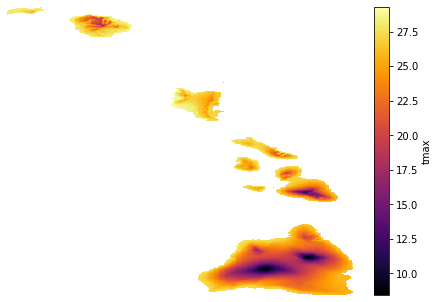

In [4]:
warnings.simplefilter('ignore', RuntimeWarning)
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off(); fig.add_axes(ax)
ds.sel(time='2009')['tmax'].mean(dim='time').plot.imshow(ax=ax,cmap='inferno')

Or we can visualize the timeseries of the minimum temperature over the past decade.

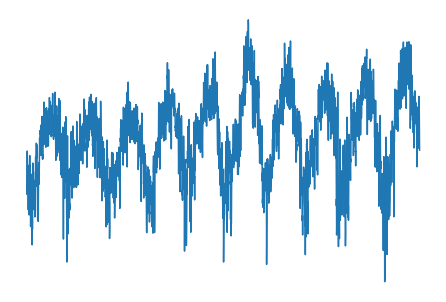

In [6]:
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off(); fig.add_axes(ax)
ds.sel(time=slice('2010', '2019'))['tmin'].mean(dim=['x','y']).plot(ax=ax)

### Chunking

Each of the datasets is chunked to allow for parallel and out-of-core or distributed processing with [Dask](https://dask.org/). The different frequencies (daily, monthly, annual) are chunked so that each year is in a single chunk. The different regions in the `x` and `y` coordinates so that no single chunk is larger than about 250 MB, which is primarily important for the `na` region.

In [7]:
ds['prcp']

<xarray.DataArray 'prcp' (time: 14600, y: 584, x: 284)>
dask.array<xarray-prcp, shape=(14600, 584, 284), dtype=float32, chunksize=(365, 584, 284), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(292, 284), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2019-12-31T12:00:00
  * x        (x) float32 -5.802e+06 -5.801e+06 -5.8e+06 ... -5.52e+06 -5.519e+06
  * y        (y) float32 -3.9e+04 -4e+04 -4.1e+04 ... -6.21e+05 -6.22e+05
Attributes:
    cell_methods:  area: mean time: sum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily total precipitation
    units:         mm/day

So our `prcp` array has a shape `(14600, 584, 284)` where each chunk is `(365, 584, 284)`. Examining the store for monthly North America, we see the chunks each have size `(12, 1250, 1250)`. 

In [8]:
na_store = fsspec.get_mapper('az://' + container_name + '/monthly/na.zarr',
                             account_name=storage_account_name)
na = xr.open_zarr(na_store, consolidated=True)
na['prcp']

<xarray.DataArray 'prcp' (time: 480, y: 8075, x: 7814)>
dask.array<xarray-prcp, shape=(480, 8075, 7814), dtype=float32, chunksize=(12, 1250, 1250), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2019-12-16T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    grid_mapping:  lambert_conformal_conic
    long_name:     monthly total precipitation
    units:         mm

See http://xarray.pydata.org/en/stable/dask.html for more on how xarray uses Dask for parallel computing. 